In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.pipeline import Pipeline, make_pipeline
from yellowbrick.regressor import ResidualsPlot
import seaborn as sns
import matplotlib.pyplot as plt
import TechBookFunctions as tb
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')


# How to Increase Average Life Expectancy #
We will be using the County Health Status Indicators dataset from the CDC to identify features in the data that most affect average life expectancy. The first step in our process is to import and clean the data. The details of the importing and cleaning the data are located in the data_import.py and data_clean.py files.

In [2]:
# this function also outputs the shapes of the resulting arrays to make sure everything is as expected
X_train, X_test, y_train, y_test, full_X, full_y = tb.import_and_clean()


2485 2485
623 623


Now that we have the fully cleaned data, we use sklearn's pipline system to perform parameter selection

## The Model ##
We chose to scale our features with the sklearn StandardScalar because we needed to standardize the units of our features, but we did not want to lose the interpretability of our regression coefficients. Using sklearn's pipeline object allows us to make sure that there is no data leakage from the scaling process during our cross validation. We decided to use the Elastic Net as our regression model because we wanted to perform feature selection but we also knew that there was some colinearity between our features.

In [3]:
# First we create a Pipeline object containing the Scaler we are using to standardize our data, and the regression model we are using
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('elastic', ElasticNet(max_iter=10000))
])

# We then create lists of parameter values to try in the model
params = {
    # this list of parametes was chosen by trial and error
    'elastic__alpha': [.001, .025, .05, .1, .4, .5, .6, .75, 1, 2, 5, 10],
    # this list of parameters is a modified list of suggested parameters from sklearn
    'elastic__l1_ratio': [.01, .05, .1, .25, .5, .6, .7,  .9, .95, .99, 1]
}

# Here we pass our pipline and params list into a GridSearch object. Grid search takes all possible combinations of parameters in the
# params dictionary and performs cross-fold validation for each combination.
search = GridSearchCV(estimator=pipe,
                      param_grid=params,
                      cv=5,  # this is the number of folds to use in the cross validation
                      return_train_score=True
                      )

# Finally we fit our full model to the training data
search.fit(X_train, y_train);


Below we have a chart with the 5 best performing combinations of parameters from our model selecting process. This chart also includes the mean testing and training training scores (correlation coefficients) for the models.

In [4]:
tb.model_selection_results(search)


,rank_test_score,param_elastic__alpha,param_elastic__l1_ratio,mean_test_score,mean_train_score
15,1,0.025,0.5,0.673764,0.682545
16,2,0.025,0.6,0.673713,0.682229
14,3,0.025,0.25,0.673647,0.683156
17,4,0.025,0.7,0.673600,0.681938
25,5,0.05,0.25,0.673534,0.681886


The final step in our model selection process is to see how the model performs on the test data from our initial train-test split. This data has not been seen by the model at all, including during the cross-validation process.

In [5]:
regressor=tb.test_model(X_test, y_test, l1_ratio=.5, alpha=.025,
              X_train=X_train, y_train=y_train)


0.6609442794839586


This result means that our model explains around 66% of the variation in the test set, which is only around 1.5% less than the cross validation testing scores. This is a good result for this model because we know that there are other factors that are not in our model (particularly demographics) that play a large part in determining life expectancy. This result gives us confidence that our model is not overfit on our training data.

In addition to just looking at the overall accuracy, we looked at the the plot of the residuals to see if there are any patterns.

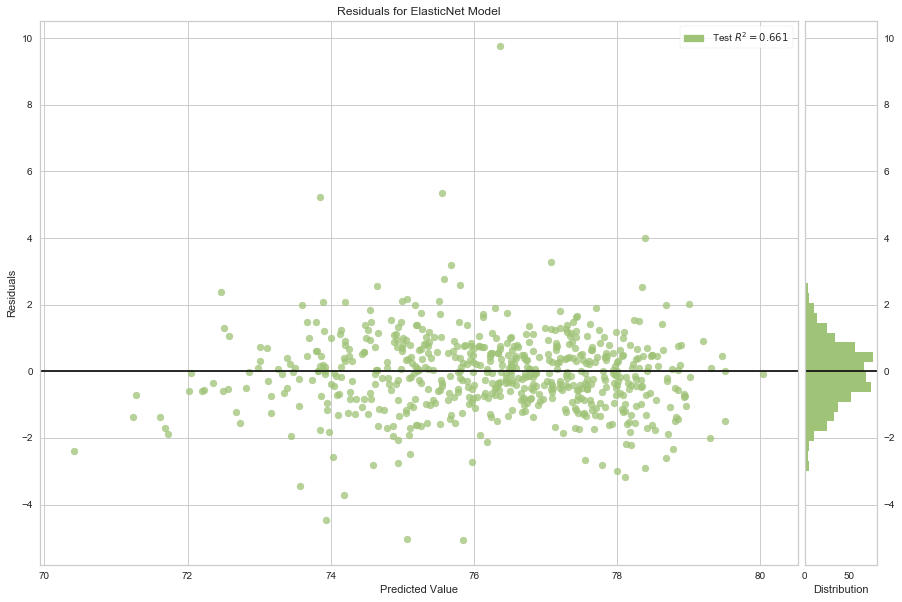

In [6]:
residuals=ResidualsPlot(regressor, is_fitted=True, size=(1080,720))
residuals.score(X_test, y_test.squeeze())
residuals.show()

Looking at the residual plot we can see that the residuals appear to be roughly normally distributed and there are no obvious patterns in the residual plot that would indicate some non-linearity or heteroskedacticity, which gives us even more confidence in the model.

## Model Results ##

Now that we have selected the best parameters for our model, we fit a model with those parameters so we can look at the individual feature coefficients.
Here are the regression coefficients as a bar plot, with a table of the values afterward.

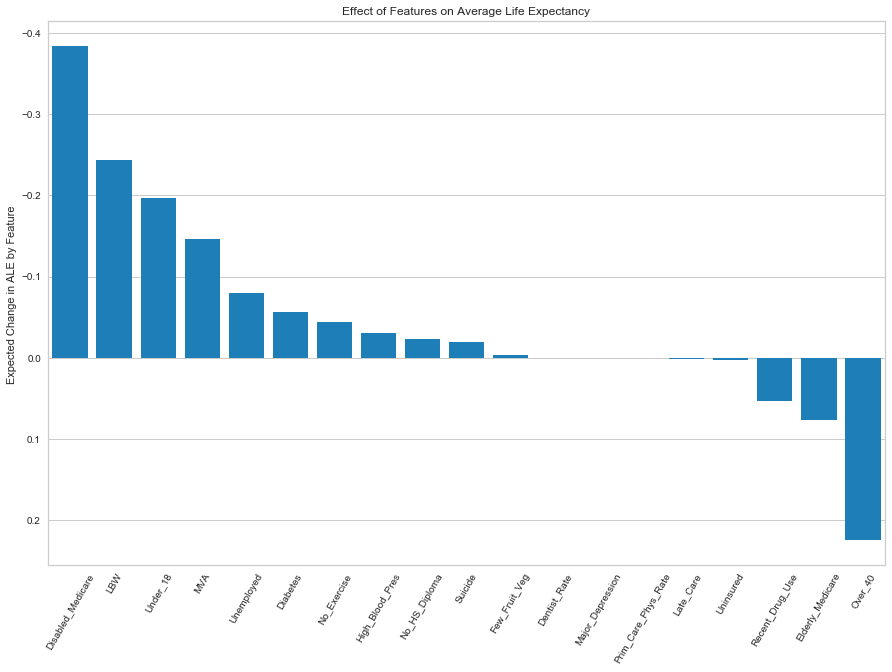

In [7]:
coefficients_table = tb.run_model(X_train, y_train, l1_ratio=.5, alpha=.025)


In [8]:
coefficients_table


,0,1
16,Disabled_Medicare,-0.384418
0,LBW,-0.243369
1,Under_18,-0.196348
4,MVA,-0.14594
7,Unemployed,-0.0796414
13,Diabetes,-0.0558811
10,No_Exercise,-0.0435934
12,High_Blood_Pres,-0.0304168
6,No_HS_Diploma,-0.0228417
5,Suicide,-0.0198188


These results are the slope coefficients in the linear regression line chosen by our model. We can interpret a coefficient, B, as saying that increasing a feature with coefficient B by one standard deviation will change the average life expectancy in a county by B years.
So, for example, our model says that decreasing the rate of low birth weight babies by one standard deviation will increase the average life expectancy by ~0.243 years, or about 88 days.

## Interpreting the results ##

According to our analysis, the most important factors for changing average life expectancy are percent of population on medicare disability, percent of babies born with low birth rate, percent of babies born to women under 18, percent of babies born to women over 40, and per capita deaths from motor vehicle accidents. Here are a few notes on some of the coefficients that seem counter-intuitive:

- Percent of the population on medicare disability has a strong negative effect on life expectancy because it is a measure of number of disabled people in a county. We found out in the documentation that the only other data in dataset measuring rates of disability had large margins of error and was unreliable, so we are using medicare disability as a measure of general disability.

- Conversely, the percent of the population on elderly medicare has a positive impact on life expectancy. This is because the calculation of average life expectancy takes into account the number of elderly people in the area, meaning that number of elderly people in a county should not be correlated with the average life expectancy. That means that measuring the percent of the population on elderly medicare in a county is measuring how many elderly people are getting regular medical attention more than overall elderly population.

- Births to women over 40 have a high positive effect on life expectancy. We suspect that is due to association between higher maternal age at birth and higher earnings.(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4723246/)

- We do not have good explanantions for why rate of uninsured people, rates of people reporting recent drug use, and percent of mothers receiving no care in the first trimester; further investigation will be needed.

Below we have included a choropleth (county level heatmap) of the united states first for Average life expectancy, and then for some of the most important features in our data for increasing life expectancy. (there are some counties missing because they did not have average life expectancy data.

In [9]:
full_data = pd.concat([full_X, full_y], axis=1)
tb.choropleth(full_data, 'ALE', 'Average Life Expectancy by County', save=True)


ImportError: geopandas, pyshp and shapely must be installed for this figure factory.

Run the following commands to install the correct versions of the following modules:

```
$ pip install geopandas==0.3.0
$ pip install pyshp==1.2.10
$ pip install shapely==1.6.3
```
If you are using Windows, follow this post to properly install geopandas and dependencies:http://geoffboeing.com/2014/09/using-geopandas-windows/

If you are using Anaconda, do not use PIP to install the packages above. Instead use conda to install them:

```
$ conda install plotly
$ conda install geopandas
```

In [ ]:
tb.choropleth(full_data, 'LBW',
              'Percentage of Births with Low Birth Weight by County', reverse=True, save=True)


In [ ]:
tb.choropleth(full_data, 'Disabled_Medicare',
              'Percentage of Population on Medicare for Disability', reverse=True, save=True)


In [ ]:
tb.choropleth(full_data, 'Under_18',
              'Percentage of Births to Women Under Age 18', reverse=True, save=True)


In [ ]:
tb.choropleth(full_data, 'Unemployed',
              'Unemployed People Per Capita. ', reverse=True, save=True)


## Recommendations ##

Based on this analysis we have some recommendations:

- The number of diabled people is our most signifigant single feature. It is hard to come up with a one-size-fits-all solution for decreasing the amount of disabled people, but looking at the choropleth there are some regions with very high disability rates suggesting some type of systemic issue like possibly pollution, workplace injuries, drugs or some other localized issue. These areas are worth investigating to see if there is something that can be done to decrease the amount of people on disability.

- Low birth weight and mothers under age 18 are both very important features in the model, so focusing on pre and post natal care, family planning services, and reproductive education would be very productive strategies to increase average life expectancy.

- Motor vehicle accidents is the next most important feature, so any efforts to increase enforcement or change traffic patterns to increase safety will have a good effect on life expectancy

- Number of elderly persons on medicare is positively associated with life expectancy, so programs to expand medicare coverage will increase life expectancy, as well as advertising and information programs to increase enrollment for eligible people.

- Jobs and/or training programs to help address unemployment will have the additional benefit of increasing average life expectancy.
